In [228]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

In [229]:
# df = pd.read_csv('data/hello.csv')
df = pd.read_csv('data/抽样提取网约车订单输出风控场景.csv',encoding = 'gbk')

In [247]:
df.shape
df = df[:6000]

In [234]:
df.columns = ['is_unpay', 'gmv_total_fee', 'p_id', 'o_id', 'returncode',
       'cur_start_distance', 'valid_start_dest_distance',
       'caller_fast_car_count_call', 'caller_count_bad',
       'caller_p_complete_order_rate', 'caller_sum_invoice_value_per_complete',
       'amt_paid_finish_orders_14_d_fast', 'cnt_pay_succ_orders_14_d_fast',
       'amt_paid_finish_orders_14_d_gulf', 'cnt_pay_succ_orders_14_d_gulf',
       'cnt_pay_succ_orders_30_d_fast', 'amt_paid_finish_orders_30_d_fast',
       'total_amt_paid_finish_orders_fast',
       'total_amt_paid_finish_orders_gulf', 'pay_success_total_fee',
       'avg_actual_amt_90_days', 'max_actual_amt_90_days',
       'count_complete_pay_90_days_orders', 'complete_orders_one_month',
       'count_complete_pay_90_days_channel', 'complete_gmv_one_month',
       'pay_order_create_time_diff_day', 'sum_gmv_3_months',
       'valid_es_pre_total_fee', 'count_ip_new_od', 'valid_product_id',
       'is_order_ip_equal', 'is_caller_pas_same_mob',
       'is_caller_city_od_area_eq', 'is_od_hot_city']
df.columns

Index(['is_unpay', 'gmv_total_fee', 'p_id', 'o_id', 'returncode',
       'cur_start_distance', 'valid_start_dest_distance',
       'caller_fast_car_count_call', 'caller_count_bad',
       'caller_p_complete_order_rate', 'caller_sum_invoice_value_per_complete',
       'amt_paid_finish_orders_14_d_fast', 'cnt_pay_succ_orders_14_d_fast',
       'amt_paid_finish_orders_14_d_gulf', 'cnt_pay_succ_orders_14_d_gulf',
       'cnt_pay_succ_orders_30_d_fast', 'amt_paid_finish_orders_30_d_fast',
       'total_amt_paid_finish_orders_fast',
       'total_amt_paid_finish_orders_gulf', 'pay_success_total_fee',
       'avg_actual_amt_90_days', 'max_actual_amt_90_days',
       'count_complete_pay_90_days_orders', 'complete_orders_one_month',
       'count_complete_pay_90_days_channel', 'complete_gmv_one_month',
       'pay_order_create_time_diff_day', 'sum_gmv_3_months',
       'valid_es_pre_total_fee', 'count_ip_new_od', 'valid_product_id',
       'is_order_ip_equal', 'is_caller_pas_same_mob',
       '

In [248]:
# 正负样本
df['is_unpay'].value_counts()
df['is_unpay'].value_counts()/df['is_unpay'].count()

0    0.907333
1    0.092667
Name: is_unpay, dtype: float64

In [249]:
feats = [feat for feat in df.columns if feat not in ['p_id','returncode']]
df2 = df[feats]

## 决策树挖掘规则

In [250]:
#!pip install toad --trusted-host didiyun.sys.xiaojukeji.com
#!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pydotplus

In [251]:
import toad
import pandas as pd
import numpy as np
import pydotplus
from IPython.display import Image
from six import StringIO
import os
from sklearn import tree

In [252]:

class auto_tree(object):
   
    def __init__(self,datasets,ex_lis,dep='bad_ind',min_samples=0.05,min_samples_leaf=200,min_samples_split=20,max_depth=4,is_bin=True):

        '''
        datasets:数据集 dataframe格式
        ex_lis：不参与建模的特征，如id，时间切片等。 list格式
        min_samples：分箱时最小箱的样本占总比 numeric格式
        max_depth：决策树最大深度 numeric格式
        min_samples_leaf：决策树子节点最小样本个数 numeric格式
        min_samples_split：决策树划分前，父节点最小样本个数 numeric格式
        is_bin：是否进行卡方分箱 bool格式（True/False）
        '''
        self.datasets = datasets
        self.ex_lis = ex_lis
        self.dep = dep
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.is_bin = is_bin

        self.bins = 0
        
    def fit_plot(self):
        os.environ["PATH"] += os.pathsep + 'graph'
        dtree = tree.DecisionTreeRegressor(max_depth=self.max_depth,
                                           min_samples_leaf=self.min_samples_leaf, 
                                           min_samples_split=self.min_samples_split)
        
        x = self.datasets.drop(self.ex_lis,axis=1)
        y = self.datasets[self.dep]
        
        if self.is_bin:
            #分箱
            combiner = toad.transform.Combiner()
            combiner.fit(x,y,method='chi',min_samples = self.min_samples)

            x_bin= combiner.transform(x)
            self.bins = combiner.export()        
        else:
            x_bin = x.copy()
            
        dtree = dtree.fit(x_bin,y) 
        
        df_bin = x_bin.copy()
        
        df_bin[self.dep] = y
        
        dot_data = StringIO()
        tree.export_graphviz(dtree, out_file=dot_data,
                                 feature_names=x_bin.columns,
                                 class_names=[self.dep],
                                 filled=True, rounded=True,
                                 special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

            
        return df_bin,self.bins,combiner,graph.create_png(),dtree

In [253]:
df_bin.columns

Index(['valid_es_pre_total_fee', 'valid_count_complete',
       'valid_sum_invoice_value', 'if_new_passenger_tag', 'valid_product_id',
       'count_device_id_new_p', 'count_device_id_newp_od',
       'valid_pre_total_fee_div_10_sub_sum_invoice', 'count_ip_new_od',
       't_moneta_order_cnt', 'is_p_mob_visual_seg',
       'caller_p_complete_order_rate', 'count_complete_3_months',
       'sum_gmv_3_months', 'app_device_id_pid_count_60',
       'app_device_id_pid_count_3', 'app_device_id_pid_count_1',
       'pid_per_app_device_id_1d', 'count_silence_1day',
       'total_amt_paid_finish_orders_fast', 'cnt_pay_succ_orders_30_d_fast',
       'amt_online_pay_l_30_fee_taxi', 'cnt_all_pay_taxi',
       'cur_start_distance', 'cnt_pay_succ_orders_14_d_gulf',
       'amt_paid_finish_orders_14_d_fast', 'amt_paid_finish_orders_30_d_fast',
       'cnt_finish_l_7_taxi', 'cnt_all_pay_l_30_taxi',
       'total_cnt_pay_succ_orders_taxi', 'amt_paid_finish_orders_14_d_gulf',
       'is_unpay'],
      dt

## 评估

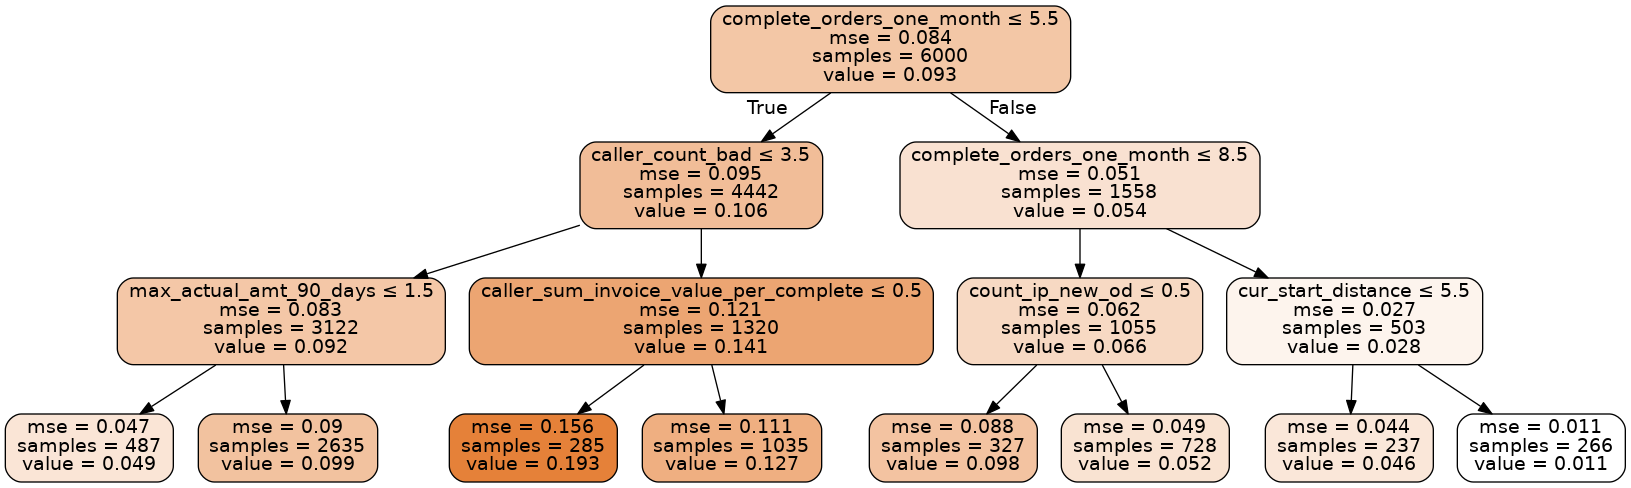

In [254]:
#指定不参与建模的变量，包含标签bad_ind
ex_lis = ['is_unpay','gmv_total_fee', 'o_id']
          #,'last_unpay_days','count_pay_120d','count_pay_90d','count_pay_28d']
#调用决策树函数
df_bin,bins,combiner,graph,dtree = auto_tree(datasets = df2,ex_lis = ex_lis,
                                       dep = 'is_unpay',min_samples=0.01,
                                       min_samples_leaf=100,max_depth=3).fit_plot()
#展示图像
Image(graph)

In [255]:
#-------------------------
# 功能：输出Python函数代码
#
#-------------------------
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
#tree_to_code(dtree, df_bin.columns)

In [257]:
#-------------------------
# 功能：输出未付率头部规则
#
#-------------------------
def tree_to_rule(tree, feature_names, bins):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    res = {}
    temp = []
    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = bins[feature_name[node]][math.floor(tree_.threshold[node])]
            temp.append("{} <= {}".format(name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            temp.pop()
            temp.append("{} > {}".format(name, threshold))
            recurse(tree_.children_right[node], depth + 1)
            temp.pop()
        else:
            rule = ' and '.join(temp)
            unpay_rate = tree_.value[node][0][0]
            o_cnt = tree_.n_node_samples[node]
            res[rule] = (unpay_rate, o_cnt)
            
    recurse(0, 1)
    return res

res = tree_to_rule(dtree, df_bin.columns, bins)
sorted(res.items(),key=lambda x:x[1][0],reverse=True)

[('complete_orders_one_month <= 14.0 and caller_count_bad > 12.0 and caller_sum_invoice_value_per_complete <= 1.03825826',
  (0.19298245614035087, 285)),
 ('complete_orders_one_month <= 14.0 and caller_count_bad > 12.0 and caller_sum_invoice_value_per_complete > 1.03825826',
  (0.12657004830917876, 1035)),
 ('complete_orders_one_month <= 14.0 and caller_count_bad <= 12.0 and max_actual_amt_90_days > 12.0',
  (0.09943074003795066, 2635)),
 ('complete_orders_one_month > 14.0 and complete_orders_one_month <= 32.0 and count_ip_new_od <= 2.0',
  (0.09785932721712538, 327)),
 ('complete_orders_one_month > 14.0 and complete_orders_one_month <= 32.0 and count_ip_new_od > 2.0',
  (0.0521978021978022, 728)),
 ('complete_orders_one_month <= 14.0 and caller_count_bad <= 12.0 and max_actual_amt_90_days <= 12.0',
  (0.049281314168377825, 487)),
 ('complete_orders_one_month > 14.0 and complete_orders_one_month > 32.0 and cur_start_distance <= 42.0',
  (0.046413502109704644, 237)),
 ('complete_orders_

In [110]:

#查看数据集中单个变量的分箱结果
print(set(df_bin['cur_start_distance']))
#查看单个变量的分箱详情
print(bins['cur_start_distance'])

{0, 1, 2}
[110.0, 3587.0]


## 评估策略

In [217]:
dt_cnt = len(df['dt'].unique())
print(df['dt'].value_counts())
print(dt_cnt)

2021-07-02    264
2021-07-01    252
2021-07-03    226
2021-07-04    150
2021-07-05    131
2021-07-06    114
2021-07-09    111
2021-07-08    103
2021-07-07    100
2021-07-10     97
Name: dt, dtype: int64
10


In [222]:
# 策略3 专快有未付
df4 = df[
    (df['effectstrategyid'].isna())&
    (df['valid_es_pre_total_fee']>=0)
]
df4['is_unpay'].agg(['sum','mean','count'])

sum        87.000000
mean        0.062861
count    1384.000000
Name: is_unpay, dtype: float64

In [226]:
print('每日命中订单数: ', df4.shape[0]/dt_cnt)
print('每日未支付订单数: ', df4['is_unpay'].sum()/dt_cnt)
print('每日未支付金额: ', (df4['is_unpay']*df4['gmv_total_fee']).sum()/dt_cnt)
print('每日影响GMV: ', df4['gmv_total_fee'].sum()/dt_cnt)
print('订单未付率: ', df4['is_unpay'].sum()/df4.shape[0])
print('金额未支付率: ', (df4['is_unpay']*df4['gmv_total_fee']).sum()/df4['gmv_total_fee'].sum())

每日命中订单数:  138.4
每日未支付订单数:  8.7
每日未支付金额:  670.96
每日影响GMV:  3572.3599999999997
订单未付率:  0.06286127167630058
金额未支付率:  0.18781981659183286
